## Dataset: Environmental Sound Classification 

## Objective

Comparison between Spectral and MFCC (Mel-frequency Cepstral Coefficients) audio extraction features in classifying environmental sound using a neural network.

## Datasets (Source & Acknowledgements)

The ESC-50 dataset is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification. https://github.com/karolpiczak/ESC-50

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories

Clips in this dataset have been manually extracted from public field recordings gathered by the Freesound.org project. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

## Importing libraries and defining helper functions

In [1]:
# import libraries

import pandas as pd
import cv2
import librosa
import numpy as np
from shutil import copyfile
import os
from tqdm import tqdm

import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# Each of the sample (22khz) lasts exactly 5 seconds with 22050 * 5 samples.

spec_hop_length = 512
mfcc_hop_length = 512
spec_max_frames = int(22050 * 5 / spec_hop_length) + 1 # this is actually about 22050 / 512.
mfcc_max_frames = int(22050 * 5 / mfcc_hop_length) + 1

num_classes = 10
max_samples = 22050 * 5  # 5 seconds
max_mfcc_features = 40

# Scale the values 

def scale(arr):
    #arr = arr - arr.mean()
    safe_max = np.abs(arr).max()
    if safe_max == 0:
        safe_max = 1
    arr = arr / safe_max
    return arr


# Load a file and convert its audio signal into a series of MFCC
# This will return a 2D numpy array.

def convert_mfcc(file_name):
    signal, sample_rate = librosa.load(file_name) 
    signal = librosa.util.normalize(signal)
    signal, index = librosa.effects.trim(signal, top_db=60)
    feature = (librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=max_mfcc_features).T)
    feature = cv2.resize(feature, (40, 216), interpolation = cv2.INTER_CUBIC)
    feature = scale(feature)
    print (feature.shape)
    return feature


# Load a file and convert its audio signal into a spectrogram
# This will return a 2D numpy array.

def convert_spectral(file_name):
    signal, sample_rate = librosa.load(file_name) 
    signal = librosa.util.normalize(signal)
    signal, index = librosa.effects.trim(signal, top_db=60)
    feature = np.abs(librosa.stft(y=signal, hop_length=spec_hop_length, win_length=spec_hop_length*4, n_fft=spec_hop_length*4, center=False).T)
    feature = librosa.amplitude_to_db(feature)
    feature = cv2.resize(feature, (224, 224), interpolation = cv2.INTER_CUBIC)
    feature = scale(feature)
    return feature    

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.

#   history - Pass in the history returned from the model.fit(...) method.

def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()  

## Setting up folders

In [3]:
# Set the folder to point to where the ESC50 dataset is,
# and also the folder to point to where to save the processed data

user_folder = './'

csv_folder = user_folder + "./meta/esc50.csv"
audio_folder = user_folder + "./audio"

## Data Preparation - Extracting the MFCC, Spectral Features

In [4]:
# Declare the labels

labels = ["chainsaw", "clock_tick", "crackling_fire", "crying_baby", "dog", "helicopter", "rain", "rooster", 
          "sea_waves", "sneezing"]

# Load up the CSV file containing data.

df = pd.read_csv(csv_folder)

# Process the wave files into spectral features.

print ("Processing...")

# Perform any initialization here.

x_spec = []
y_spec = []
x_mfcc = []
y_mfcc = []

sample_count = 0

# Loops through the data in the CSV and process only those audio files that
# belong to one of the ten labels.


for index, row in df.iterrows():   
    df_10 = df[df["category"].isin(labels)]
    df_10 = df_10.drop(['fold','esc10','src_file','take'], axis=1)
    classes = df_10['category'].unique()
    class_dict = {i:x for x,i in enumerate(classes)}
    df_10['target'] = df_10['category'].map(class_dict)    
    
    # Extract the spectral features by calling the convert_spectral
    # function.

for data in tqdm(df_10.iterrows(),  desc='Progress'):
    spec_feat = convert_spectral(audio_folder + "/" + data[1][0])
    x_spec.append(spec_feat) 
    y_hot = [0] * 10
    y_hot[data[1][1]] = 1
    y_spec.append(y_hot)

for data in tqdm(df_10.iterrows(),  desc='Progress'):
    mfcc_feat = convert_mfcc(audio_folder + "/" + data[1][0])
    x_mfcc.append(mfcc_feat)
    y_hot = [0] * 10
    y_hot[data[1][1]] = 1
    y_mfcc.append(y_hot)

x_mfcc = np.array(x_mfcc)
x_spec = np.array(x_spec)
y_mfcc = np.array(y_mfcc)
y_spec = np.array(y_spec)
    
# By the end of these codes, you should have 8 Numpy arrays:
#    x_spec_train, 
#    x_spec_test, 
#    y_spec_train, 
#    y_spec_test,

#    x_mfcc_train, 
#    x_mfcc_test,
#    y_mfcc_train, 
#    y_mfcc_test


x_spec = x_spec.reshape(x_spec.shape[0], x_spec.shape[1], x_spec.shape[2], 1)

x_spec_train, x_spec_test, y_spec_train, y_spec_test = train_test_split(x_spec, y_spec, train_size=0.8)

x_mfcc = x_mfcc.reshape(x_mfcc.shape[0], x_mfcc.shape[1], x_mfcc.shape[2], 1)

x_mfcc_train, x_mfcc_test, y_mfcc_train, y_mfcc_test = train_test_split(x_mfcc, y_mfcc, train_size=0.8)

print ("Processing complete.")

Processing...


Progress: 400it [00:43,  9.13it/s]
Progress: 1it [00:00,  8.84it/s]

(216, 40)
(216, 40)


Progress: 4it [00:00,  9.74it/s]

(216, 40)
(216, 40)


Progress: 5it [00:00,  9.14it/s]

(216, 40)
(216, 40)


Progress: 8it [00:00,  9.24it/s]

(216, 40)
(216, 40)


Progress: 9it [00:00,  8.99it/s]

(216, 40)
(216, 40)


Progress: 11it [00:01,  9.13it/s]

(216, 40)
(216, 40)


Progress: 13it [00:01,  9.17it/s]

(216, 40)
(216, 40)


Progress: 16it [00:01,  9.14it/s]

(216, 40)
(216, 40)


Progress: 18it [00:01,  8.95it/s]

(216, 40)
(216, 40)


Progress: 19it [00:02,  8.85it/s]

(216, 40)
(216, 40)


Progress: 22it [00:02,  9.16it/s]

(216, 40)
(216, 40)


Progress: 24it [00:02,  9.22it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 27it [00:02,  9.26it/s]

(216, 40)
(216, 40)


Progress: 29it [00:03,  9.03it/s]

(216, 40)
(216, 40)


Progress: 30it [00:03,  9.02it/s]

(216, 40)
(216, 40)


Progress: 32it [00:03,  9.19it/s]

(216, 40)
(216, 40)


Progress: 35it [00:03,  9.33it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 38it [00:04,  9.13it/s]

(216, 40)
(216, 40)


Progress: 39it [00:04,  9.02it/s]

(216, 40)
(216, 40)


Progress: 41it [00:04,  9.18it/s]

(216, 40)
(216, 40)


Progress: 44it [00:04,  9.55it/s]

(216, 40)
(216, 40)


Progress: 46it [00:04,  9.15it/s]

(216, 40)
(216, 40)


Progress: 48it [00:05,  9.08it/s]

(216, 40)
(216, 40)


Progress: 50it [00:05,  8.84it/s]

(216, 40)
(216, 40)


Progress: 52it [00:05,  8.73it/s]

(216, 40)
(216, 40)


Progress: 54it [00:05,  8.86it/s]

(216, 40)
(216, 40)


Progress: 56it [00:06,  8.78it/s]

(216, 40)
(216, 40)


Progress: 57it [00:06,  8.76it/s]

(216, 40)
(216, 40)


Progress: 60it [00:06,  9.03it/s]

(216, 40)
(216, 40)


Progress: 63it [00:06,  9.17it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 65it [00:07,  8.80it/s]

(216, 40)
(216, 40)


Progress: 67it [00:07,  8.81it/s]

(216, 40)
(216, 40)


Progress: 69it [00:07,  8.55it/s]

(216, 40)
(216, 40)


Progress: 71it [00:07,  8.70it/s]

(216, 40)
(216, 40)


Progress: 73it [00:08,  8.93it/s]

(216, 40)
(216, 40)


Progress: 75it [00:08,  9.10it/s]

(216, 40)
(216, 40)


Progress: 76it [00:08,  9.19it/s]

(216, 40)
(216, 40)


Progress: 78it [00:08,  9.37it/s]

(216, 40)
(216, 40)


Progress: 81it [00:08,  9.34it/s]

(216, 40)
(216, 40)


Progress: 83it [00:09,  8.89it/s]

(216, 40)
(216, 40)


Progress: 84it [00:09,  8.98it/s]

(216, 40)
(216, 40)


Progress: 87it [00:09,  8.81it/s]

(216, 40)
(216, 40)


Progress: 89it [00:09,  8.63it/s]

(216, 40)
(216, 40)


Progress: 91it [00:10,  8.81it/s]

(216, 40)
(216, 40)


Progress: 93it [00:10,  8.65it/s]

(216, 40)
(216, 40)


Progress: 95it [00:10,  8.80it/s]

(216, 40)
(216, 40)


Progress: 97it [00:10,  8.79it/s]

(216, 40)
(216, 40)


Progress: 99it [00:10,  9.02it/s]

(216, 40)
(216, 40)


Progress: 101it [00:11,  9.20it/s]

(216, 40)
(216, 40)


Progress: 102it [00:11,  8.95it/s]

(216, 40)
(216, 40)


Progress: 105it [00:11,  9.13it/s]

(216, 40)
(216, 40)


Progress: 106it [00:11,  8.93it/s]

(216, 40)
(216, 40)


Progress: 110it [00:12,  9.35it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 112it [00:12,  9.35it/s]

(216, 40)
(216, 40)


Progress: 114it [00:12,  9.12it/s]

(216, 40)
(216, 40)


Progress: 116it [00:12,  9.25it/s]

(216, 40)
(216, 40)


Progress: 117it [00:12,  9.25it/s]

(216, 40)
(216, 40)


Progress: 120it [00:13,  9.39it/s]

(216, 40)
(216, 40)


Progress: 122it [00:13,  9.40it/s]

(216, 40)
(216, 40)


Progress: 123it [00:13,  9.17it/s]

(216, 40)
(216, 40)


Progress: 126it [00:13,  9.35it/s]

(216, 40)
(216, 40)


Progress: 127it [00:14,  9.28it/s]

(216, 40)
(216, 40)


Progress: 129it [00:14,  9.35it/s]

(216, 40)
(216, 40)


Progress: 132it [00:14,  9.38it/s]

(216, 40)
(216, 40)


Progress: 134it [00:14,  9.35it/s]

(216, 40)
(216, 40)


Progress: 135it [00:14,  9.34it/s]

(216, 40)
(216, 40)


Progress: 138it [00:15,  9.46it/s]

(216, 40)
(216, 40)


Progress: 140it [00:15,  9.37it/s]

(216, 40)
(216, 40)


Progress: 142it [00:15,  9.36it/s]

(216, 40)
(216, 40)


Progress: 143it [00:15,  9.20it/s]

(216, 40)
(216, 40)


Progress: 146it [00:16,  9.29it/s]

(216, 40)
(216, 40)


Progress: 148it [00:16,  9.36it/s]

(216, 40)
(216, 40)


Progress: 150it [00:16,  9.22it/s]

(216, 40)
(216, 40)


Progress: 151it [00:16,  9.23it/s]

(216, 40)
(216, 40)


Progress: 154it [00:16,  9.36it/s]

(216, 40)
(216, 40)


Progress: 156it [00:17,  9.30it/s]

(216, 40)
(216, 40)


Progress: 157it [00:17,  9.35it/s]

(216, 40)
(216, 40)


Progress: 159it [00:17,  9.40it/s]

(216, 40)
(216, 40)


Progress: 163it [00:17,  9.92it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 165it [00:18,  9.60it/s]

(216, 40)
(216, 40)


Progress: 167it [00:18,  9.31it/s]

(216, 40)
(216, 40)


Progress: 168it [00:18,  9.34it/s]

(216, 40)
(216, 40)


Progress: 171it [00:18,  9.31it/s]

(216, 40)
(216, 40)


Progress: 173it [00:18,  9.26it/s]

(216, 40)
(216, 40)


Progress: 174it [00:19,  9.27it/s]

(216, 40)
(216, 40)


Progress: 178it [00:19,  9.47it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 180it [00:19,  9.58it/s]

(216, 40)
(216, 40)


Progress: 183it [00:19,  9.54it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 185it [00:20,  9.59it/s]

(216, 40)
(216, 40)


Progress: 186it [00:20,  9.34it/s]

(216, 40)
(216, 40)


Progress: 189it [00:20,  9.40it/s]

(216, 40)
(216, 40)


Progress: 191it [00:20,  9.29it/s]

(216, 40)
(216, 40)


Progress: 193it [00:21,  9.39it/s]

(216, 40)
(216, 40)


Progress: 196it [00:21,  9.45it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 198it [00:21,  9.54it/s]

(216, 40)
(216, 40)


Progress: 200it [00:21,  9.42it/s]

(216, 40)
(216, 40)


Progress: 203it [00:22,  9.45it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 205it [00:22,  9.54it/s]

(216, 40)
(216, 40)


Progress: 206it [00:22,  9.10it/s]

(216, 40)
(216, 40)


Progress: 209it [00:22,  9.35it/s]

(216, 40)
(216, 40)


Progress: 210it [00:22,  9.30it/s]

(216, 40)
(216, 40)


Progress: 213it [00:23,  9.32it/s]

(216, 40)
(216, 40)


Progress: 214it [00:23,  9.26it/s]

(216, 40)
(216, 40)


Progress: 216it [00:23,  9.20it/s]

(216, 40)
(216, 40)


Progress: 219it [00:23,  9.35it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 222it [00:24,  9.43it/s]

(216, 40)
(216, 40)


Progress: 225it [00:24,  9.60it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 227it [00:24,  9.42it/s]

(216, 40)
(216, 40)


Progress: 229it [00:24,  9.36it/s]

(216, 40)
(216, 40)


Progress: 231it [00:25,  9.01it/s]

(216, 40)
(216, 40)


Progress: 233it [00:25,  9.01it/s]

(216, 40)
(216, 40)


Progress: 235it [00:25,  9.21it/s]

(216, 40)
(216, 40)


Progress: 237it [00:25,  9.00it/s]

(216, 40)
(216, 40)


Progress: 239it [00:26,  8.91it/s]

(216, 40)
(216, 40)


Progress: 241it [00:26,  9.02it/s]

(216, 40)
(216, 40)


Progress: 243it [00:26,  9.27it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 246it [00:26,  9.10it/s]

(216, 40)
(216, 40)


Progress: 248it [00:26,  9.23it/s]

(216, 40)
(216, 40)


Progress: 250it [00:27,  9.07it/s]

(216, 40)
(216, 40)


Progress: 252it [00:27,  9.09it/s]

(216, 40)
(216, 40)


Progress: 254it [00:27,  9.21it/s]

(216, 40)
(216, 40)


Progress: 256it [00:27,  9.26it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 260it [00:28,  9.62it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 262it [00:28,  9.41it/s]

(216, 40)
(216, 40)


Progress: 263it [00:28,  9.22it/s]

(216, 40)
(216, 40)


Progress: 265it [00:28,  9.29it/s]

(216, 40)
(216, 40)


Progress: 269it [00:29,  9.37it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 271it [00:29,  9.30it/s]

(216, 40)
(216, 40)


Progress: 272it [00:29,  9.26it/s]

(216, 40)
(216, 40)


Progress: 275it [00:29,  9.44it/s]

(216, 40)
(216, 40)


Progress: 277it [00:30,  9.39it/s]

(216, 40)
(216, 40)


Progress: 278it [00:30,  9.33it/s]

(216, 40)
(216, 40)


Progress: 281it [00:30,  9.46it/s]

(216, 40)
(216, 40)


Progress: 283it [00:30,  9.38it/s]

(216, 40)
(216, 40)


Progress: 284it [00:30,  9.31it/s]

(216, 40)
(216, 40)


Progress: 288it [00:31,  9.57it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 290it [00:31,  9.55it/s]

(216, 40)
(216, 40)


Progress: 292it [00:31,  9.22it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 294it [00:31,  9.37it/s]

(216, 40)
(216, 40)


Progress: 296it [00:32,  9.37it/s]

(216, 40)
(216, 40)


Progress: 299it [00:32,  9.44it/s]

(216, 40)
(216, 40)


Progress: 302it [00:32,  9.47it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 304it [00:32,  9.32it/s]

(216, 40)
(216, 40)


Progress: 306it [00:33,  9.38it/s]

(216, 40)
(216, 40)


Progress: 308it [00:33,  9.22it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 311it [00:33,  9.26it/s]

(216, 40)
(216, 40)


Progress: 313it [00:33,  9.29it/s]

(216, 40)
(216, 40)


Progress: 315it [00:34,  9.36it/s]

(216, 40)
(216, 40)


Progress: 316it [00:34,  9.10it/s]

(216, 40)
(216, 40)


Progress: 319it [00:34,  9.28it/s]

(216, 40)
(216, 40)


Progress: 320it [00:34,  9.39it/s]

(216, 40)
(216, 40)


Progress: 323it [00:35,  9.44it/s]

(216, 40)
(216, 40)


Progress: 325it [00:35,  9.39it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 328it [00:35,  9.33it/s]

(216, 40)
(216, 40)


Progress: 330it [00:35,  9.31it/s]

(216, 40)
(216, 40)


Progress: 333it [00:36,  9.44it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 335it [00:36,  9.35it/s]

(216, 40)
(216, 40)


Progress: 337it [00:36,  9.35it/s]

(216, 40)
(216, 40)


Progress: 338it [00:36,  9.30it/s]

(216, 40)
(216, 40)


Progress: 341it [00:36,  9.35it/s]

(216, 40)
(216, 40)


Progress: 343it [00:37,  9.34it/s]

(216, 40)
(216, 40)


Progress: 345it [00:37,  9.20it/s]

(216, 40)
(216, 40)


Progress: 346it [00:37,  9.22it/s]

(216, 40)
(216, 40)


Progress: 350it [00:37,  9.49it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 352it [00:38,  9.37it/s]

(216, 40)
(216, 40)


Progress: 354it [00:38,  9.20it/s]

(216, 40)
(216, 40)


Progress: 356it [00:38,  9.01it/s]

(216, 40)
(216, 40)


Progress: 358it [00:38,  9.04it/s]

(216, 40)
(216, 40)


Progress: 360it [00:39,  9.23it/s]

(216, 40)
(216, 40)


Progress: 361it [00:39,  9.04it/s]

(216, 40)
(216, 40)


Progress: 364it [00:39,  9.31it/s]

(216, 40)
(216, 40)


Progress: 366it [00:39,  9.31it/s]

(216, 40)
(216, 40)
(216, 40)


Progress: 369it [00:39,  9.28it/s]

(216, 40)
(216, 40)


Progress: 370it [00:40,  9.42it/s]

(216, 40)
(216, 40)


Progress: 373it [00:40,  9.42it/s]

(216, 40)
(216, 40)


Progress: 374it [00:40,  9.23it/s]

(216, 40)
(216, 40)


Progress: 377it [00:40,  9.36it/s]

(216, 40)
(216, 40)


Progress: 379it [00:41,  9.11it/s]

(216, 40)
(216, 40)


Progress: 381it [00:41,  9.11it/s]

(216, 40)
(216, 40)


Progress: 383it [00:41,  8.88it/s]

(216, 40)
(216, 40)


Progress: 385it [00:41,  8.95it/s]

(216, 40)
(216, 40)


Progress: 387it [00:41,  8.57it/s]

(216, 40)
(216, 40)


Progress: 388it [00:42,  8.69it/s]

(216, 40)
(216, 40)


Progress: 391it [00:42,  9.12it/s]

(216, 40)
(216, 40)


Progress: 393it [00:42,  9.19it/s]

(216, 40)
(216, 40)


Progress: 395it [00:42,  9.30it/s]

(216, 40)
(216, 40)


Progress: 397it [00:43,  9.13it/s]

(216, 40)
(216, 40)


Progress: 399it [00:43,  9.28it/s]

(216, 40)
(216, 40)


Progress: 400it [00:43,  9.22it/s]

(216, 40)
Processing complete.


In [5]:
# Ensure that the following arrays are converted to Numpy
# arrays and have the following shapes:

#    x_spec_train.shape    (320, 224, 224, 1)
#    x_spec_test.shape     (80, 224, 224, 1)
#    y_spec_train.shape    (320, 10)
#    y_spec_test.shape     (80, 10)
#
#    x_mfcc_train.shape    (320, 216, 40, 1)
#    x_mfcc_test.shape     (80, 216, 40, 1)
#    y_mfcc_train.shape    (320, 10)
#    y_mfcc_test.shape     (80, 10)

print (x_spec_train.shape)
print (x_spec_test.shape)
print (y_spec_train.shape)
print (y_spec_test.shape)

print (x_mfcc_train.shape)
print (x_mfcc_test.shape)
print (y_mfcc_train.shape)
print (y_mfcc_test.shape)

(320, 224, 224, 1)
(80, 224, 224, 1)
(320, 10)
(80, 10)
(320, 216, 40, 1)
(80, 216, 40, 1)
(320, 10)
(80, 10)


## Data Visualization

In [6]:
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df

,filename,target,category
0,1-100032-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
62,1-17367-A-10.wav,4,rain
78,1-187207-A-20.wav,5,crying_baby
110,1-21934-A-38.wav,6,clock_tick
136,1-26143-A-21.wav,7,sneezing
141,1-26806-A-1.wav,8,rooster
148,1-28135-A-11.wav,9,sea_waves


In [7]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(audio_folder + './' + row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc

10it [00:01,  8.90it/s]


## Visualizing samples of audio wave plots

In [8]:
def wave_plot(signal):
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(15,20))
    fig.suptitle('Time series',size=20)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

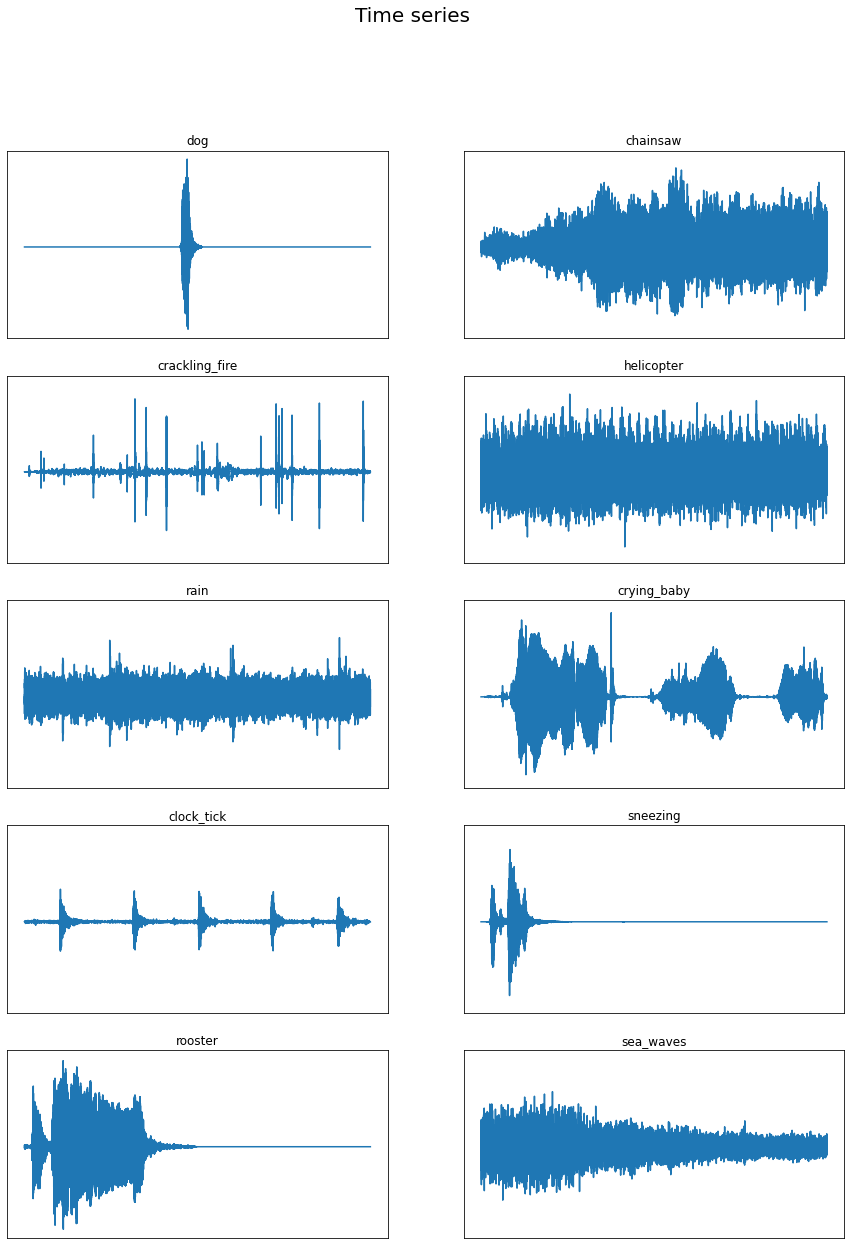

In [9]:
wave_plot(signals)

## Visualizing spectrograms of audio samples

In [10]:
def spectrogram(mfccs, cmap=None):
    fig ,axes= plt.subplots(nrows=5 , ncols=2 , sharex=False, sharey=True , figsize=(15,20))
    fig.suptitle('Mel_Spectrogram',size=20)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

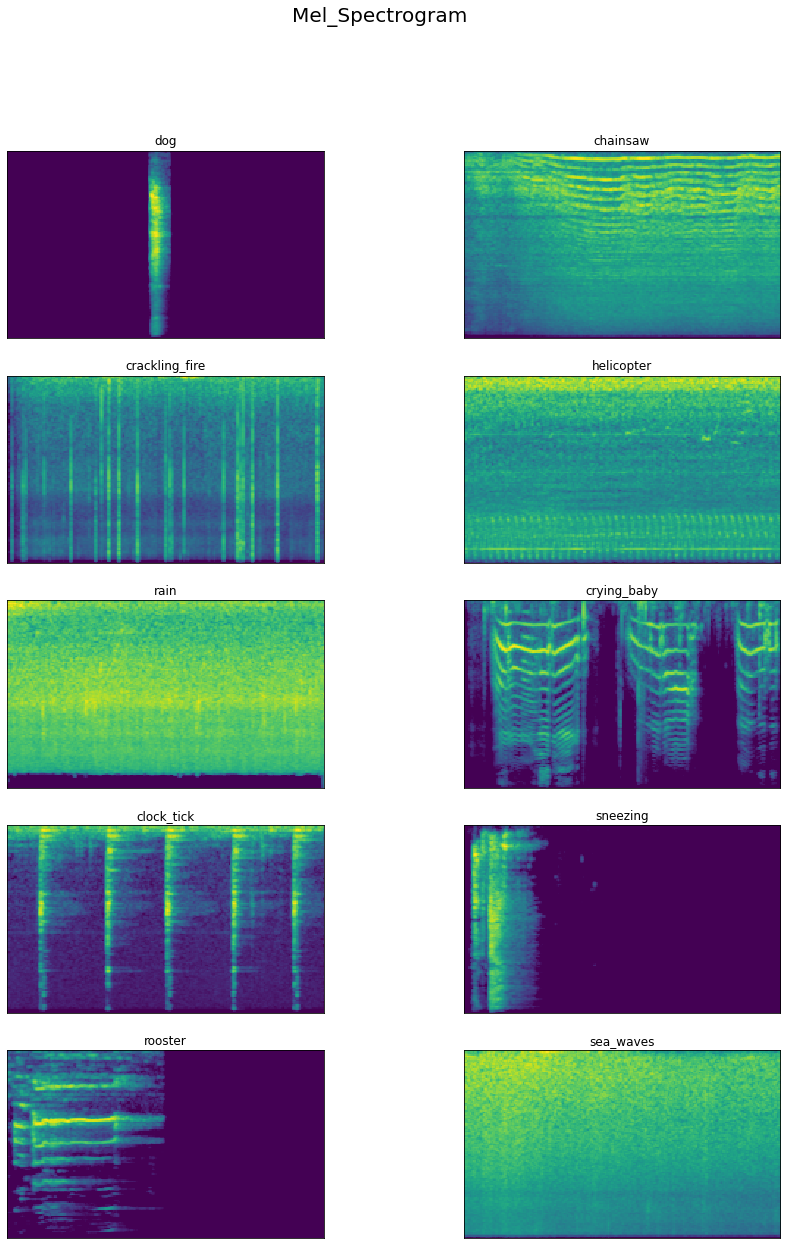

In [11]:
spectrogram(mel_spectrograms)

## Modelling

## Creating and Training the Model (for Spectral Features)

.//a1_spec_train_2023-06-06 16-18-00
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 dropout (Dropout) 

Epoch 46/500
32/32 [==============================] - 15s 476ms/step - loss: 0.4291 - accuracy: 0.8594 - val_loss: 0.7232 - val_accuracy: 0.8250
Epoch 47/500
32/32 [==============================] - 15s 473ms/step - loss: 0.3170 - accuracy: 0.8844 - val_loss: 0.7679 - val_accuracy: 0.6625
Epoch 48/500
32/32 [==============================] - 15s 474ms/step - loss: 0.3793 - accuracy: 0.8656 - val_loss: 0.6971 - val_accuracy: 0.7875
Epoch 49/500
32/32 [==============================] - 15s 473ms/step - loss: 0.4380 - accuracy: 0.8531 - val_loss: 0.8308 - val_accuracy: 0.7375
Epoch 50/500
32/32 [==============================] - 15s 473ms/step - loss: 0.3306 - accuracy: 0.9000 - val_loss: 0.7012 - val_accuracy: 0.8875
Epoch 51/500
32/32 [==============================] - 15s 475ms/step - loss: 0.3058 - accuracy: 0.9000 - val_loss: 0.7626 - val_accuracy: 0.7875
Epoch 52/500
32/32 [==============================] - 15s 479ms/step - loss: 0.3348 - accuracy: 0.8625 - val_loss: 0.7135 - val_ac

32/32 [==============================] - 15s 473ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4361 - val_accuracy: 0.8625
Epoch 159/500
32/32 [==============================] - 15s 472ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.4079 - val_accuracy: 0.8750
Epoch 160/500
32/32 [==============================] - 15s 474ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.8750
Epoch 161/500
32/32 [==============================] - 15s 474ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.4259 - val_accuracy: 0.8750
Epoch 162/500
32/32 [==============================] - 15s 474ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.3772 - val_accuracy: 0.8875
Epoch 163/500
32/32 [==============================] - 15s 474ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.8875
Epoch 164/500
32/32 [==============================] - 15s 474ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.3965 - val_accuracy:

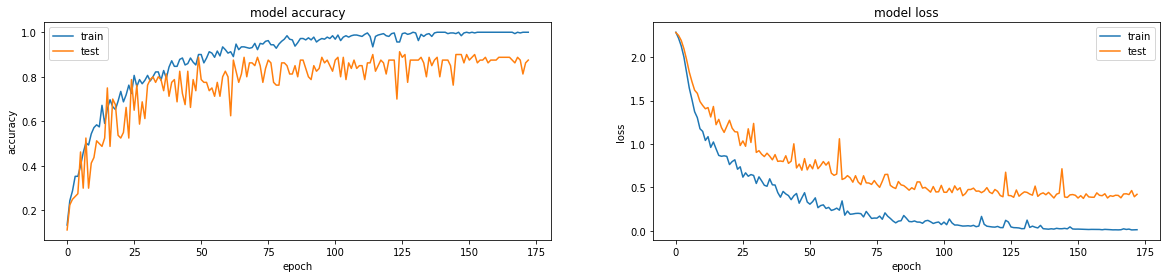

3/3 [==============================] - 1s 270ms/step


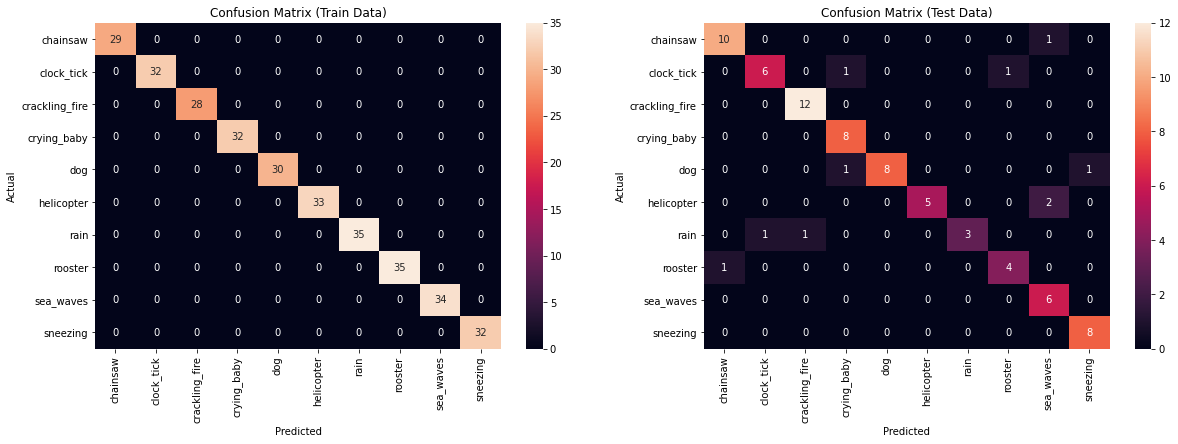

Train Data:
--------------------------------------------------------
                precision    recall  f1-score   support

      chainsaw       1.00      1.00      1.00        29
    clock_tick       1.00      1.00      1.00        32
crackling_fire       1.00      1.00      1.00        28
   crying_baby       1.00      1.00      1.00        32
           dog       1.00      1.00      1.00        30
    helicopter       1.00      1.00      1.00        33
          rain       1.00      1.00      1.00        35
       rooster       1.00      1.00      1.00        35
     sea_waves       1.00      1.00      1.00        34
      sneezing       1.00      1.00      1.00        32

      accuracy                           1.00       320
     macro avg       1.00      1.00      1.00       320
  weighted avg       1.00      1.00      1.00       320


Test Data:
--------------------------------------------------------
                precision    recall  f1-score   support

      chainsaw    

In [12]:
def create_spec_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1))) #Spec
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(10, activation='softmax'))
    return model

# Create the training folder

training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = user_folder + '/a1_spec_train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)
print (training_session_folder)


# Create the model and compile it.

spec_model = create_spec_model()
spec_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])
print(spec_model.summary())

# Configure the checkpoint and stop point.
# This allows the training to save the best models and also stop the
# training early if it detects that there are no improvements after a long time.

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/a1_spec_model.{epoch:04d}-acc-{accuracy:4.2f}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]

# Train the Spectral model

history_spec = spec_model.fit(x_spec_train, y_spec_train, epochs=500, verbose=True, validation_data=(x_spec_test, y_spec_test), callbacks=callbacks_list, batch_size=10)


#  Display the confusion matrix and classification report.

import matplotlib.pyplot as plt

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.

# history - Pass in the history returned from the model.fit(...) method.

def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

display_training_loss_and_accuracy(history_spec)


#------------------------------------------------------------------------------------------

def display_classification_confusion_matrix(keras_model, x_spec_train, y_spec_train, x_spec_test, y_spec_test, labels):

    x_spec_train = np.array(x_spec_train)
    y_spec_train = np.array(y_spec_train)
    
    actual_y_spec_train = keras_model.predict(x_spec_train)
    actual_y_spec_test = keras_model.predict(x_spec_test)

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    
    y_spec_train_index = y_spec_train.argmax(axis=1)
    actual_y_spec_train_index = actual_y_spec_train.argmax(axis=1)
    y_spec_test_index = y_spec_test.argmax(axis=1)
    actual_y_spec_test_index = actual_y_spec_test.argmax(axis=1)

    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_spec_train_index, actual_y_spec_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
       
    cm = confusion_matrix(y_spec_test_index, actual_y_spec_test_index)

    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_spec_train_index, y_spec_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_spec_test_index, y_spec_test_index, target_names=labels))
    

# Exclude the O tags from the confusion matrix.

display_classification_confusion_matrix(spec_model, x_spec_train, y_spec_train, x_spec_test, y_spec_test, labels)


## Creating and Training the Model (for MFCC Features)

.//a1_mfcc_train_2023-06-06 17-01-50
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 214, 38, 64)       640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 107, 19, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 105, 17, 128)      73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 52, 8, 128)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 6, 256)        295168    
                                                                 
 dropout_1 (Dropo

32/32 [==============================] - 3s 79ms/step - loss: 0.2681 - accuracy: 0.8969 - val_loss: 0.8386 - val_accuracy: 0.7875
Epoch 104/500
32/32 [==============================] - 2s 75ms/step - loss: 0.1804 - accuracy: 0.9375 - val_loss: 0.8024 - val_accuracy: 0.7875
Epoch 105/500
32/32 [==============================] - 2s 75ms/step - loss: 0.1802 - accuracy: 0.9438 - val_loss: 0.9776 - val_accuracy: 0.7375
Epoch 106/500
32/32 [==============================] - 2s 75ms/step - loss: 0.1829 - accuracy: 0.9500 - val_loss: 0.8950 - val_accuracy: 0.8000
Epoch 107/500
32/32 [==============================] - 2s 75ms/step - loss: 0.2067 - accuracy: 0.9281 - val_loss: 0.8321 - val_accuracy: 0.7500
Epoch 108/500
32/32 [==============================] - 2s 76ms/step - loss: 0.1613 - accuracy: 0.9688 - val_loss: 0.8271 - val_accuracy: 0.8125
Epoch 109/500
32/32 [==============================] - 2s 78ms/step - loss: 0.1919 - accuracy: 0.9406 - val_loss: 0.8497 - val_accuracy: 0.7750
Epoch 

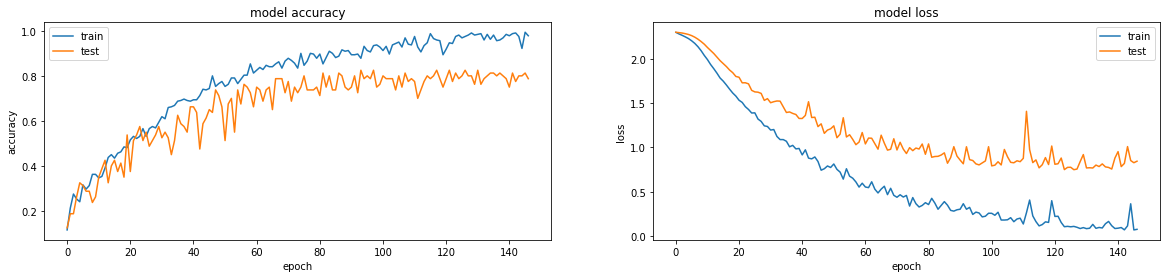

3/3 [==============================] - 0s 40ms/step


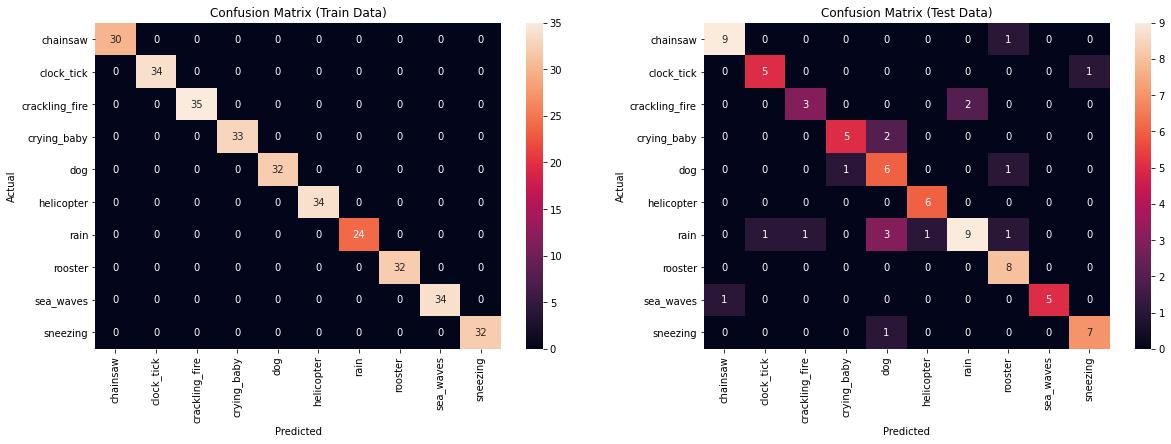

Train Data:
--------------------------------------------------------
                precision    recall  f1-score   support

      chainsaw       1.00      1.00      1.00        30
    clock_tick       1.00      1.00      1.00        34
crackling_fire       1.00      1.00      1.00        35
   crying_baby       1.00      1.00      1.00        33
           dog       1.00      1.00      1.00        32
    helicopter       1.00      1.00      1.00        34
          rain       1.00      1.00      1.00        24
       rooster       1.00      1.00      1.00        32
     sea_waves       1.00      1.00      1.00        34
      sneezing       1.00      1.00      1.00        32

      accuracy                           1.00       320
     macro avg       1.00      1.00      1.00       320
  weighted avg       1.00      1.00      1.00       320


Test Data:
--------------------------------------------------------
                precision    recall  f1-score   support

      chainsaw    

In [13]:
def create_mfcc_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(216, 40, 1))) #MFCC
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(10, activation='softmax'))
    return model

# Create the training folder

training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = user_folder + '/a1_mfcc_train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)
print (training_session_folder)


# Create the model and compile it.

mfcc_model = create_mfcc_model()
mfcc_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])
print(mfcc_model.summary())


# Configure the checkpoint and stop point.
# This allows the training to save the best models and also stop the
# training early if it detects that there are no improvements after a long time.

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/a1_mfcc_model.{epoch:04d}-acc-{accuracy:4.2f}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]

# Train the MFCC model

history_mfcc = mfcc_model.fit(x_mfcc_train, y_mfcc_train, epochs=500, verbose=True, validation_data=(x_mfcc_test, y_mfcc_test), callbacks=callbacks_list, batch_size=10)

# Display the confusion matrix and classification report.

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.

#   history - Pass in the history returned from the model.fit(...) method.

def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

display_training_loss_and_accuracy(history_mfcc)


#------------------------------------------------------------------------------------------

def display_classification_confusion_matrix(keras_model, x_mfcc_train, y_mfcc_train, x_mfcc_test, y_mfcc_test, labels):

    x_mfcc_train = np.array(x_mfcc_train)
    y_mfcc_train = np.array(y_mfcc_train)
    
    actual_y_mfcc_train = keras_model.predict(x_mfcc_train)
    actual_y_mfcc_test = keras_model.predict(x_mfcc_test)

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    
    y_mfcc_train_index = y_mfcc_train.argmax(axis=1)
    actual_y_mfcc_train_index = actual_y_mfcc_train.argmax(axis=1)
    y_mfcc_test_index = y_mfcc_test.argmax(axis=1)
    actual_y_mfcc_test_index = actual_y_mfcc_test.argmax(axis=1)

    
    # Print the first Confusion Matrix for the training data
    
    cm = confusion_matrix(y_mfcc_train_index, actual_y_mfcc_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    
    cm = confusion_matrix(y_mfcc_test_index, actual_y_mfcc_test_index)

    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_mfcc_train_index, y_mfcc_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_mfcc_test_index, y_mfcc_test_index, target_names=labels))
    

# Exclude the O tags from the confusion matrix.

display_classification_confusion_matrix(mfcc_model, x_mfcc_train, y_mfcc_train, x_mfcc_test, y_mfcc_test, labels)

## Conclusion

Spectral audio features performed much better than MFCC audio features in classification of the environmental sounds, based on the accuracy scores of 0.88 vs. 0.79 as observed by the confusion matrix and classification reports.

## End of Notebook